Install/import python packages, set additional notebook rules and define useful constants:

# MCA Analysis on Automobile Dataset 

This notebook aims to apply Multiple Correspondence Analysis (EDA) to know better [Automobile Dataset](https://www.kaggle.com/datasets/toramky/automobile-dataset/) - categorical variables - and to infer characteristics of the data which will be used into AI model construction and training. Here we select MCA since we have multiple categorical variables.

The MCA represents categorical variable as points in multidimensional space such that we catch the maximum amount of variation.

We use the MCA for the following aims: (1) evaluate interrelations of the cars according to attribute categorical values, (2) evaluate the importance of the categorical attributes of the cars ,(3) combine PCA on numeric variables and MCA on categorical variables to build a model, (4) Conclusions - results of the MCA analysis 
 

In [1]:
!pip install prince

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from copy import deepcopy
import matplotlib.pyplot as plt

import numpy as np
import os 
import pandas as pd 
import prince
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from ydata_profiling import profile_report

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [4]:
PROJECT_PATHNAME = globals()['_dh'][1].resolve().parents[0]
FILE_PATHNAME = os.path.join(PROJECT_PATHNAME, 'data/Automobile_data.csv')

Open data file, sample first rows, set '?' elements to 0

In [5]:
df =  pd.read_csv(FILE_PATHNAME)


In [6]:
df.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Define categorical attributes of automobile data, print out category data and all category feature values :

In [8]:
quant_attr = ["normalized-losses", "price", "wheel-base", "length", "width", "height", "curb-weight", "engine-size", "bore", "stroke", "compression-ratio",
              "horsepower", "peak-rpm", "city-mpg", "highway-mpg"]
cat_attr = ["symboling", "make", "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels", "engine-location", "engine-type", "num-of-cylinders", "fuel-system"]

In [9]:


df[cat_attr].head(5)
df.replace('?', np.nan, inplace = True)
df_cat_attr = df[cat_attr] 

In [10]:

# See what categories there are in each categorical feature
for col in cat_attr:
    print (col, df[col].unique())
    mode_cat = df_cat_attr[col].mode()[0]
    df_cat_attr[col].fillna(mode_cat,inplace=True)
        

symboling [ 3  1  2  0 -1 -2]
make ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen'
 'volvo']
fuel-type ['gas' 'diesel']
aspiration ['std' 'turbo']
num-of-doors ['two' 'four' nan]
body-style ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
drive-wheels ['rwd' 'fwd' '4wd']
engine-location ['front' 'rear']
engine-type ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
num-of-cylinders ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
fuel-system ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']


#### 1. Evaluate interrelations of the cars according to attribute categorical values 

In [11]:
df[cat_attr]

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,3,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo,gas,std,four,sedan,rwd,front,ohc,four,mpfi
201,-1,volvo,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi
202,-1,volvo,gas,std,four,sedan,rwd,front,ohcv,six,mpfi
203,-1,volvo,diesel,turbo,four,sedan,rwd,front,ohc,six,idi


In [12]:
# instantiate MCA class
mca = prince.MCA(n_components = 2)
# get principal components
mca = mca.fit(df_cat_attr)

#mca = mca.transform(df[cat_attr])

# project categories onto mca copmonents
# implicitly calls transform(X)
# what we want to see is for the points belonging to the same color to be as far apart as possible, for all colors
#mca.plot(df[cat_attr])
mca.plot(df[cat_attr])

#ax.get_figure()


alt.Chart(...)

### 2. Evaluate the importance of the categorical attributes of the cars 

In [20]:
df_cat_attr['symboling'] = df_cat_attr['symboling'].astype(str)
df_cat_attr_dummy = pd.get_dummies(df_cat_attr, drop_first=True)
print(df_cat_attr.shape)
print(df_cat_attr_dummy.shape)
print("Features after get_dummies:\n", list(df_cat_attr_dummy.columns))

(205, 11)
(205, 55)
Features after get_dummies:
 ['symboling_-2', 'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche', 'make_renault', 'make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel-type_gas', 'aspiration_turbo', 'num-of-doors_two', 'body-style_hardtop', 'body-style_hatchback', 'body-style_sedan', 'body-style_wagon', 'drive-wheels_fwd', 'drive-wheels_rwd', 'engine-location_rear', 'engine-type_dohcv', 'engine-type_l', 'engine-type_ohc', 'engine-type_ohcf', 'engine-type_ohcv', 'engine-type_rotor', 'num-of-cylinders_five', 'num-of-cylinders_four', 'num-of-cylinders_six', 'num-of-cylinders_three', 'num-of-cylinders_twelve', 'num-of-cylinders_two', 'fuel-system_2bbl', 'fuel-system_4bbl', 'fuel-system_idi', 'fuel-system_

In [21]:
X = df_cat_attr_dummy.drop('symboling_-2', axis=1) # input categorical features
y = df_cat_attr_dummy['symboling_-2'] # target variable

# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)

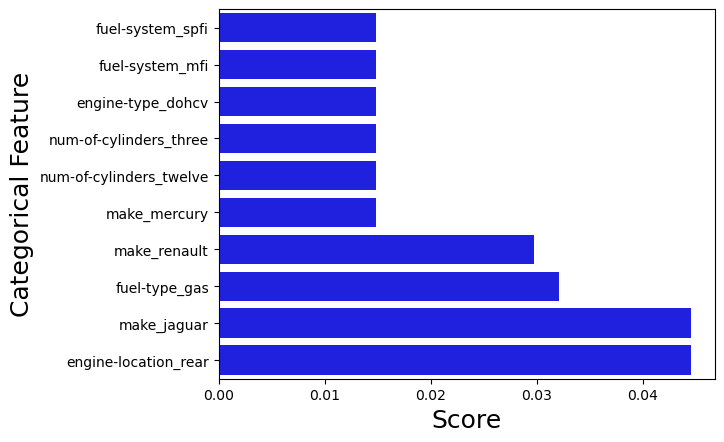

In [22]:
# plot the scores
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=True)
sns.barplot(x=datset['scores'][:10], y=datset['feature'][:10], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()


In [23]:
X1 = df_cat_attr.drop('symboling', axis=1) # input features
y1 = df_cat_attr['symboling'] # target variable
print(X1.info())
# prepare input features
oe = OrdinalEncoder()
oe.fit(X1)
X_enc = oe.transform(X1)

# prepare target variable
le = LabelEncoder()
le.fit(y1)
y_enc = le.transform(y1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   make              205 non-null    object
 1   fuel-type         205 non-null    object
 2   aspiration        205 non-null    object
 3   num-of-doors      205 non-null    object
 4   body-style        205 non-null    object
 5   drive-wheels      205 non-null    object
 6   engine-location   205 non-null    object
 7   engine-type       205 non-null    object
 8   num-of-cylinders  205 non-null    object
 9   fuel-system       205 non-null    object
dtypes: object(10)
memory usage: 16.1+ KB
None


In [ ]:
# feature selection
sf = SelectKBest(chi2, k='all')
sf_fit1 = sf.fit(X_enc, y_enc)


In [24]:
# plot the scores of features
datset1 = pd.DataFrame()
datset1['feature'] = X1.columns[ range(len(sf_fit1.scores_))]
datset1['scores'] = sf_fit1.scores_
datset1 = datset1.sort_values(by='scores', ascending=True)
sns.barplot(x=datset1['scores'], y=datset1['feature'], color='green')
sns.set_style('whitegrid')
plt.ylabel('Categorical feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

NameError: name 'sf_fit1' is not defined

#### 3. Combine PCA on numeric variables and MCA on categorical variables to build a model

In [ ]:
df_quant_attr = df[quant_attr]
for col in quant_attr:
    print (col, df[col].unique())
    mean_cat = df_quant_attr[col].mean()
    df_quant_attr[col].fillna(mean_cat,inplace=True)

In [ ]:
df['normalized-losses'] = df['normalized-losses'].astype(int)
df['bore'] = df['bore'].astype(float)
df['stroke'] = df['stroke'].astype(float)
df['horsepower'] = df['horsepower'].astype(int)
df['peak-rpm'] = df['peak-rpm'].astype(int)
df['price'] = df['price'].astype(int)

In [ ]:
# instantiate PCA class
pca = prince.PCA(n_components = 2)

# get princical components
pca = pca.fit(df[quant_attr])

